In [3]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
import os
from dotenv import load_dotenv
load_dotenv(os.path.join('../../config/','.env'))  
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

## Define tools

We will also define some tools that our agents will use in the future

In [4]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## Create graph

Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

### Define State

We first define the state of the graph. This will just a list of messages, along with a key to track the most recent sender

In [5]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_ollama import ChatOllama



# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

### Define Agent Nodes

We now need to define the nodes. First, let's define the nodes for the agents.

In [6]:
import functools

from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOllama(
        model="llama3.1"
        # model="llama3-groq-tool-use",
    )

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

### Define Tool Node

We now define a node to run the tools

In [7]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

### Define Edge Logic

We can define some of the edge logic that is needed to decide what to do based on results of the agents

In [8]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router  
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

### Define the Graph

We can now put it all together and define the graph!

In [9]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.add_edge(START, "Researcher")
graph = workflow.compile()

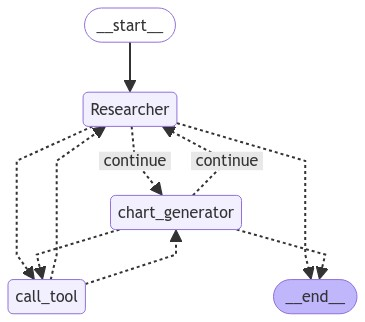

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Invoke

With the graph created, you can invoke it! Let's have it chart some stats for us.

In [11]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'Researcher': {'messages': [AIMessage(content='', response_metadata={'model': 'llama3.1', 'created_at': '2024-09-02T19:18:58.36024775Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'tavily_search_results_json', 'arguments': {'query': 'UK GDP over past 5 years'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 30972891124, 'load_duration': 2113197882, 'prompt_eval_count': 317, 'prompt_eval_duration': 23561779000, 'eval_count': 27, 'eval_duration': 5254146000}, name='Researcher', id='run-7188f76a-5d63-45b2-842a-14056e45ac03-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP over past 5 years'}, 'id': 'f4e1e6c3-f6ee-4ff0-9865-1fd2eb39f83e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 317, 'output_tokens': 27, 'total_tokens': 344})], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [ToolMessage(content='[{"url": "https://www.statista.com/topics/3795/gdp-of-the-uk/", "content": "Monthly gro